# Variable Stars
# Santiago Lastra Ramírez
# C.C 1001367476

In [1]:
from astroquery.gaia import Gaia
from astropy.visualization import hist
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.table import unique
from astroquery.mast import Catalogs
from scipy.spatial import distance
import pandas as pd
from astropy.table import Table,vstack
from tqdm import tqdm
from gatspy.periodic import LombScargleFast
from gatspy.periodic import LombScargle
from sklearn.mixture import GaussianMixture as GMM

load_esasky = True

if load_esasky:
    from pyesasky import ESASkyWidget
    from pyesasky import Catalogue
    from pyesasky.cooFrame   import CooFrame
    
plt.style.use('classic')
#%matplotlib nbagg

# 1.

In [2]:
user_name = 'slastra'
Gaia.login(user = user_name) # Also: Gaia.login()

INFO: Login to gaia TAP server [astroquery.gaia.core]
Password: ········
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


Se crea un cone search de gaia para M4 con coordenadas RA:16 23 35.22, DEC:-26 31 32.7 y un radio de 7.3 minutos de arco. Se eliminan las estrellas con paralaje negativo, con errores mayores al 10%, con NANs y con paralajes que estuvieran por fuera de 2$\sigma$.

In [3]:
radius  = 7.3/60    # Degrees
inp_ra  = 245.896914  # Degrees
inp_dec = -26.52575  # Degrees

query = f"SELECT * FROM gaiaedr3.gaia_source \
WHERE 1=CONTAINS(POINT({inp_ra}, {inp_dec}),CIRCLE(ra, dec, {radius})) AND \
ruwe <1.4 AND parallax_over_error >10 AND parallax>0"

In [4]:
job     = Gaia.launch_job_async(query)
results = job.get_results().to_pandas()

#Se eliminan NANs
results = results.dropna(subset = ['parallax']).reset_index()

#Se eliminan los no pertenecientes a 2*sigma
results = results[results['parallax']>(np.mean(results['parallax'])-2*np.std(results['parallax']))]
results = results[results['parallax']<(np.mean(results['parallax'])+2*np.std(results['parallax']))]

print(f'Table size (rows): {len(results)}')
results[0:5]

INFO: Query finished. [astroquery.utils.tap.core]
Table size (rows): 1192


,index,solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
0,0,1636042515805110273,Gaia EDR3 6045460008676109184,6045460008676109184,1072355179,2016.0,245.896662,0.029510,-26.641849,0.017845,...,NaN,NaN,0,NaN,NaN,NaN,350.883581,15.894091,248.505673,-4.983333
1,1,1636042515805110273,Gaia EDR3 6045460008676121344,6045460008676121344,411091704,2016.0,245.895413,0.018185,-26.635873,0.010924,...,NaN,NaN,0,NaN,NaN,NaN,350.887395,15.898940,248.503589,-4.977618
2,2,1636042515805110273,Gaia EDR3 6045460038725004416,6045460038725004416,568038452,2016.0,245.917060,0.031560,-26.642536,0.019012,...,NaN,NaN,0,NaN,NaN,NaN,350.895815,15.880146,248.523842,-4.981039
3,3,1636042515805110273,Gaia EDR3 6045460043035815040,6045460043035815040,1671914807,2016.0,245.924302,0.025576,-26.643391,0.015379,...,NaN,NaN,0,NaN,NaN,NaN,350.899687,15.874784,248.530392,-4.980828
4,4,1636042515805110273,Gaia EDR3 6045460073084746112,6045460073084746112,576230133,2016.0,245.929792,0.046963,-26.638935,0.028213,...,NaN,NaN,0,NaN,NaN,NaN,350.906547,15.874154,248.534523,-4.975632


# 2. y 3.

Ya teniendo las estrellas de M4 del catálogo de Gaia se procede a buscarlas en Panstarrs para obtener la fotometría multi-época y se escoge la estrella que tenga una menor distancia al conesearch (ya que el conesearch puede albergar a más de 1 estrella). 

Finalmente se guardan todas los DataFrames de la fotometría de las estrellas extraídas de Panstarrs en una lista.

In [5]:
df=[]
for i in range(len(results)):
    try:
        a=Catalogs.query_object(f"{results.loc[i, 'ra']} {results.loc[i, 'dec']}",
                                radius= 1/3600, catalog='Panstarrs', data_release= 'dr2', table='detections')
    
        if len(a)<10:
            continue
    except:
        continue
    
    b=a[a["distance"]==min(a["distance"])].to_pandas() #Por si en el conesearch hay varias estrellas
    b=b.dropna(subset = ["psfFluxErr","psfFlux"]).reset_index(drop=True) #Se eliminan los NANs
    b=b[b["psfFluxErr"]/b["psfFlux"]<0.1] #Si el error porcentual del flujo es menor al 10%
    df.append(b)

Cantidad de estrellas con datos fotométricos

In [6]:
print(len(df))

1148


# 4.

Para determinar cuáles son estrellas variables y cuáles no, se decide tomar a cada una de las estrellas, calcularle el flujo medio de los datos fotométricos multi-época y luego calcular la distancia que hay entre la media del flujo y el flujo que está más alejado de esta media. Finalmente con esta distancia se hace un histograma para todas las estrellas y se eliminan todas aquellas que tienen esta distancia menor a la media más un sigma.

In [7]:
variable=[]
for i in range(len(df)):
    media=np.mean(df[i]["psfFlux"])
    
    try: # Se crea este try para no tomar los dataframes que están vacíos
        maximo=max(df[i]["psfFlux"])
    except:
        continue
    variable.append(abs(maximo-media))

print(f"La cantidad de datos es {len(variable)}\nLa media es {np.mean(variable)}\nLa desviacion estándar es {np.std(variable)}\nLa media más un sigma es {np.mean(variable)+np.std(variable)}")

La cantidad de datos es 1144
La media es 0.012826034270692737
La desviacion estándar es 0.08367796893843275
La media más un sigma es 0.09650400320912549


<IPython.core.display.Javascript object>


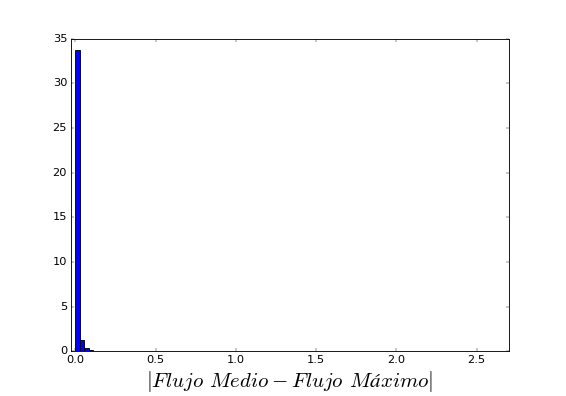

In [8]:
plt.figure(dpi=70,figsize=(10,7))
plt.hist(variable, bins = 'scott', edgecolor='k', density=1)
plt.xlabel('$|Flujo$ $Medio-Flujo$ $Máximo|$',fontsize = 24,fontweight='bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(-0.03,2.7)
#plt.savefig('Histogram_Flux.png')
plt.show()

Se toman los datos fotométricos multi-época de las estrellas variables.

In [9]:
star_almostvariable=[] #Estrellas que son variables
for i in range(len(variable)):
    if variable[i]>np.mean(variable)+np.std(variable):
        star_almostvariable.append(df[i])

Gráfica del flujo de una de las estrellas

<IPython.core.display.Javascript object>


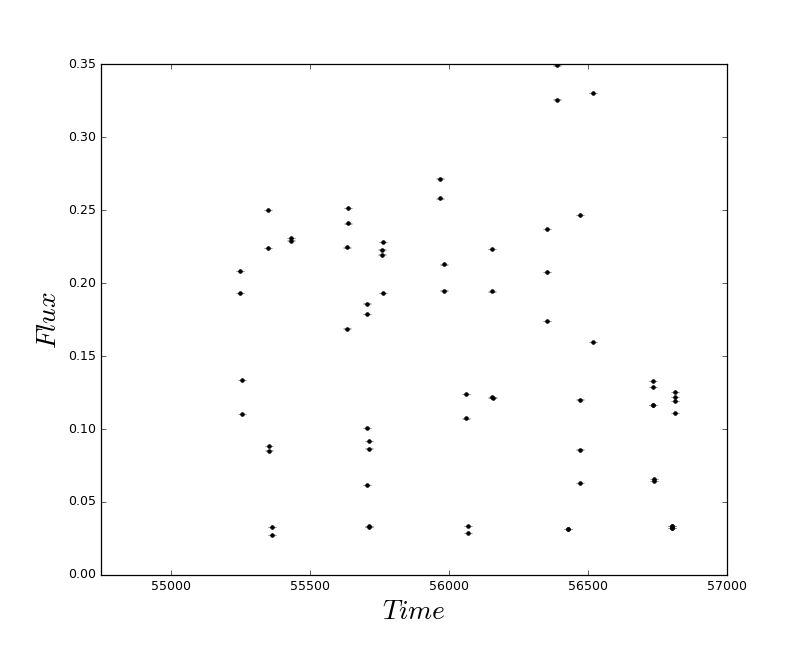

In [10]:
fig, ax = plt.subplots(figsize=(10,8))

ax.errorbar(star_almostvariable[7]['obsTime'], star_almostvariable[7]['psfFlux'], 
            yerr= star_almostvariable[7]['psfFluxErr'], fmt='.k', ecolor='gray')
ax.set_xlim(54750,57000)
ax.set_xlabel('$Time$',fontsize=22)
ax.set_ylabel('$Flux$',fontsize=22)
#plt.savefig('CurvaLuz.png')
plt.show()

In [11]:
period=[]
power=[]
periodo=[]
star_variable=[]
for i in range(len(star_almostvariable)):
    mode=LombScargle().fit(star_almostvariable[i]["obsTime"],star_almostvariable[i]["psfFlux"],
                               star_almostvariable[i]["psfFluxErr"])
    period.append(mode.periodogram_auto(nyquist_factor=100)[0])
    power.append(mode.periodogram_auto(nyquist_factor=100)[1])
    
    if period[i][np.argmax(power[i])]<2: #Condición para que se cumpla que es una estrella variable y no una
                                         #binaria eclipsante
        periodo.append(period[i][np.argmax(power[i])])
        star_variable.append(star_almostvariable[i])

Se grafica el power extraído por LombScargle de una de las estrellas variables

<IPython.core.display.Javascript object>


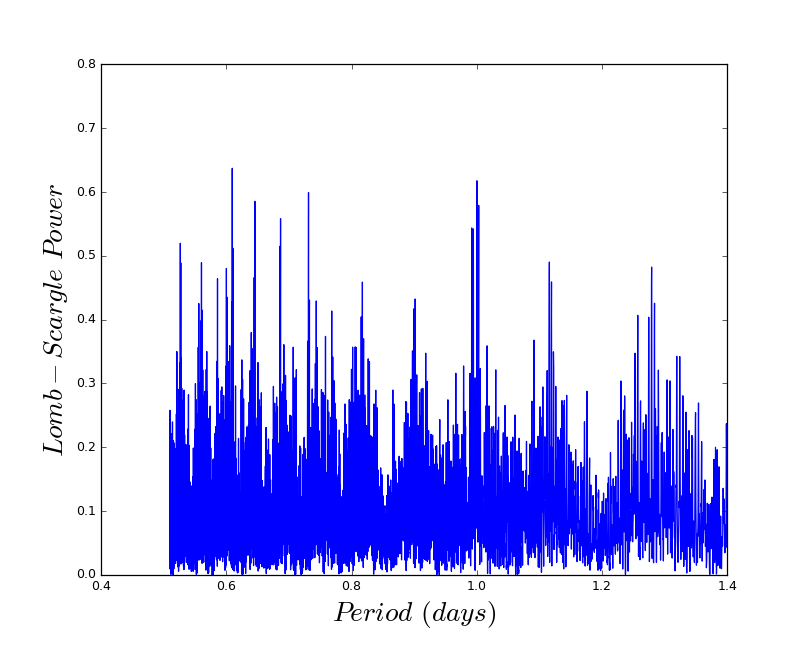

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(period[1], power[1])
ax.set(xlim=(0.4, 1.4), ylim=(0, 0.8),xlabel='$Period$ $(days)$',ylabel='$Lomb-Scargle$ $Power$')
ax.set_xlabel('$Period$ $(days)$',fontsize=22)
ax.set_ylabel('$Lomb-Scargle$ $Power$',fontsize=22)
plt.show()

Ahora ya habiendo tomado las estrellas variables se procede a graficar las curvas de luz para cada una de las estrellas.

<IPython.core.display.Javascript object>


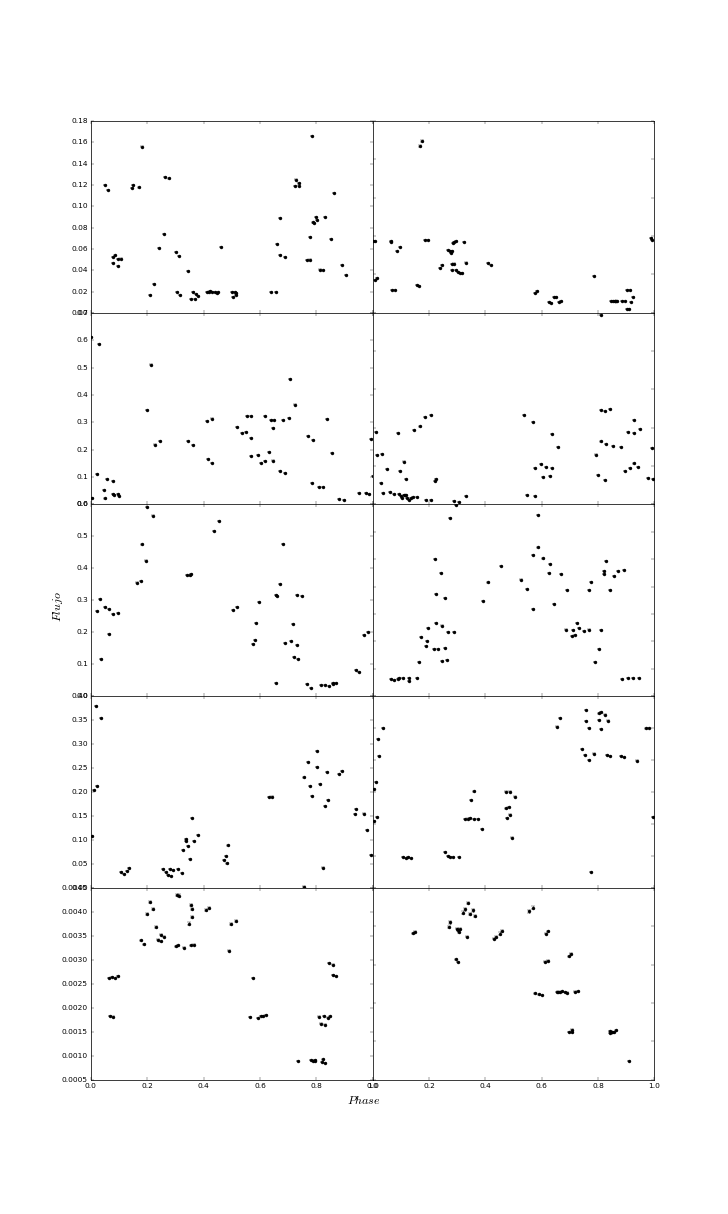

In [13]:
fig, axs = plt.subplots(5,2,figsize=(15,25),dpi=60,sharex=True,sharey=False)
fig.subplots_adjust(hspace=0,wspace=0)

k=0

for i in range(5):
    for j in range(2):            
        phase = (star_variable[k]['obsTime']/periodo[k])%1
        axs[i,j].errorbar(phase,star_variable[k].psfFlux,yerr=star_variable[k].psfFluxErr,fmt="ko",markersize=4)
        k+=1
        
for ax in axs.flat:
    ax.label_outer()
    
fig.text(0.5, 0.09, '$Phase$', ha='center',fontsize = 16)
fig.text(0.07, 0.5, '$Flujo$', va='center', rotation='vertical',fontsize = 16)
#plt.savefig("Curvas",dpi=400,bbox_inches="tight")
plt.show()        

# 5.

Finalmente de obtener el periodo se procede a hacer uso de GMM para clasificar las estrellas variables en estrellas de periodo largo o en estrellas de periodo corto

In [14]:
datos=pd.DataFrame(np.transpose([periodo,np.ones_like(periodo)]),columns=["periodo","ones"])
X=datos[["periodo","ones"]]
k=2
gmm = GMM(k, covariance_type='full', random_state=0)
gmm.fit(X)
label=gmm.predict(X)
C=[]
for i in range(k):
    C.append(datos[label==i])

<IPython.core.display.Javascript object>


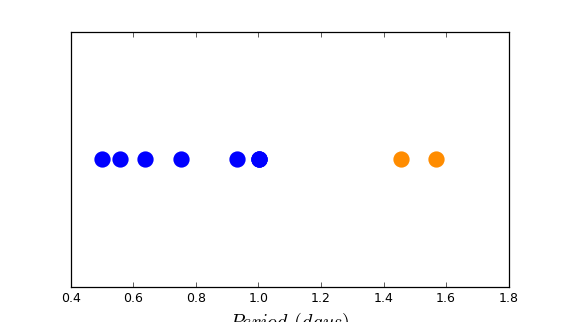

In [18]:
plt.figure(figsize=(7,4))
plt.scatter(C[0].periodo,C[0].ones,s=100,label=f"{i}",linewidth=3,color="blue")
plt.scatter(C[1].periodo,C[1].ones,s=100,label=f"{i}",linewidth=3,color="darkorange",marker="o")
plt.xlabel('$Period$ $(days)$',fontsize = 16,fontweight='bold')
plt.yticks([])
plt.savefig("Long-Short Period",dpi=400)
plt.show()